In [1]:
import os
import cv2

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
import tensorflow_addons as tfa

AUTOTUNE = tf.data.experimental.AUTOTUNE

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import image as Image

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

import warnings
warnings.simplefilter('ignore')

Number of replicas: 1


In [3]:
#We have been given .tfrec files and jpeg, for the project we will use .tfrec files
path = 'C:/Users/Rakhat/Documents/dl project'
monet_filenames = tf.io.gfile.glob(str(path + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(monet_filenames))

photo_filenames = tf.io.gfile.glob(str(path + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(monet_filenames))

Monet TFRecord Files: 5
Photo TFRecord Files: 5


In [4]:
monet_filenames[0]

'C:\\Users\\Rakhat\\Documents\\dl project\\monet_tfrec\\monet00-60.tfrec'

(256, 256, 3)


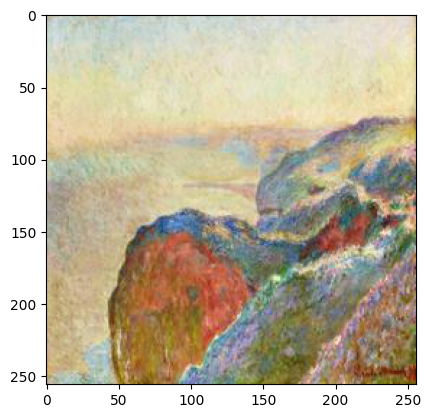

In [5]:
image_monet = Image.imread(path + '/monet_jpg/000c1e3bff.jpg')
print(image_monet.shape)
plt.imshow(image_monet)
plt.show()

(256, 256, 3)


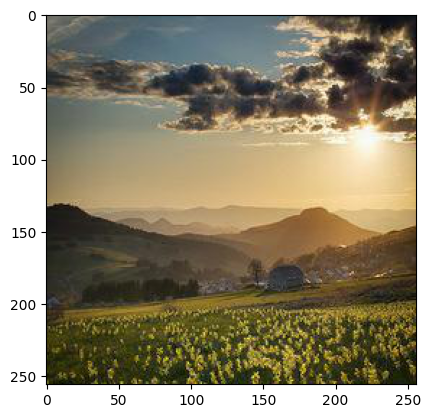

In [6]:
image_others = Image.imread(path + '/photo_jpg/00068bc07f.jpg')
print(image_others.shape)
plt.imshow(image_others)
plt.show()

In [7]:
monet_jpg_filepath = path + "/monet_jpg"
photo_jpg_filepath = path + "/photo_jpg"

In [8]:
monet_image_paths = []
for dirname, _, filenames in os.walk(monet_jpg_filepath):
    for filename in filenames:
        fullpath = os.path.join(dirname, filename)
        monet_image_paths.append(fullpath)
monet_image_paths[:2]

['C:/Users/Rakhat/Documents/dl project/monet_jpg\\000c1e3bff.jpg',
 'C:/Users/Rakhat/Documents/dl project/monet_jpg\\011835cfbf.jpg']

In [9]:
others_image_paths = []
for dirname, _, filenames in os.walk(photo_jpg_filepath):
    for filename in filenames:
        fullpath = os.path.join(dirname, filename)
        others_image_paths.append(fullpath)
others_image_paths[:2]

['C:/Users/Rakhat/Documents/dl project/photo_jpg\\00068bc07f.jpg',
 'C:/Users/Rakhat/Documents/dl project/photo_jpg\\000910d219.jpg']

In [10]:
print('Number of Other Images:', len(others_image_paths))

Number of Other Images: 7038


In [11]:
print('Number of Monet Images:', len(others_image_paths))


Number of Monet Images: 7038


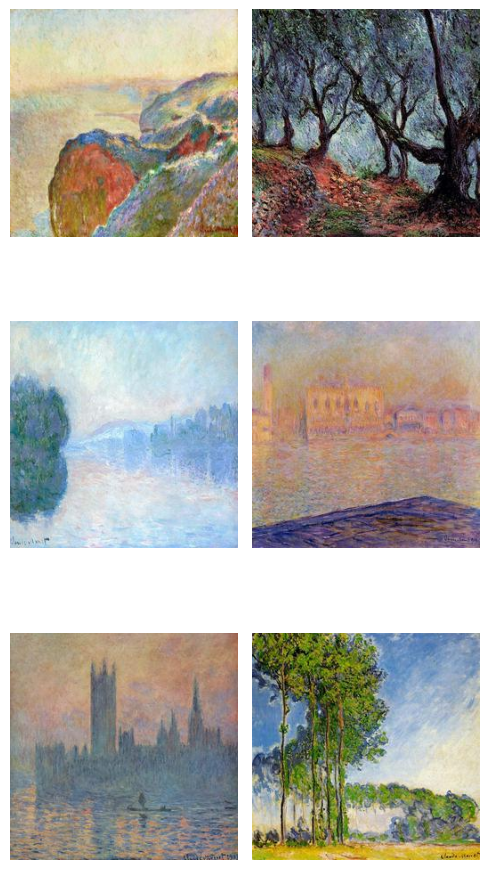

In [12]:
figure, ax = plt.subplots(nrows = 3,ncols = 2,figsize=(5,10))
for i, image_path in enumerate(monet_image_paths):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    try:
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    except:
        continue;
        
plt.tight_layout()
plt.show()

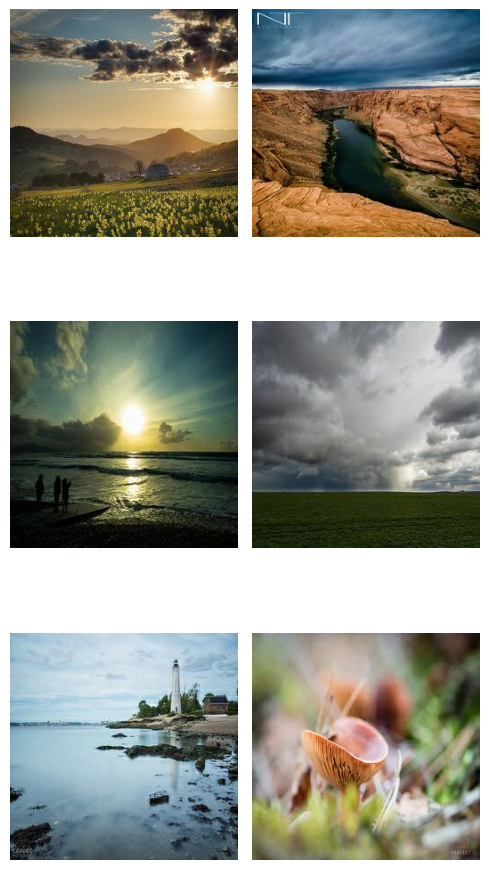

In [13]:
figure, ax = plt.subplots(nrows = 3,ncols = 2,figsize=(5,10))
for i, image_path in enumerate(others_image_paths):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    try:
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    except:
        continue;
        
plt.tight_layout()
plt.show()

In [14]:
image_size = [256, 256]

In [15]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [16]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
    return dataset

In [17]:
monet_df = load_dataset(monet_filenames, labeled=True).batch(1)
photo_df = load_dataset(photo_filenames, labeled=True).batch(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


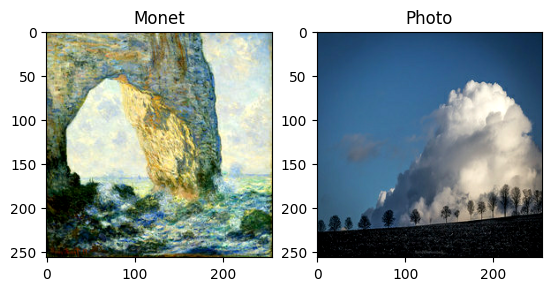

In [18]:
plt.subplot(121)
plt.title('Monet')
plt.imshow(next(iter(monet_df))[0]*0.6 + 0.5)

plt.subplot(122)
plt.title('Photo')
plt.imshow(next(iter(photo_df))[0]*0.6 + 0.5)

In [19]:
output_channels = 3

#In downsample we will use Conv2D to reduce the size of the image

def downsample(filters, size, instancenorm = True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    model = keras.Sequential()
    model.add(tfl.Conv2D(filters = filters, kernel_size = size, strides = 2, padding='same',
                             kernel_initializer = initializer, use_bias=False))

    if instancenorm:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))

    model.add(tfl.LeakyReLU())

    return model

In [20]:
# In upsample we will use Conv2DTranspose to increase the size of the image, stride = 2 will 
# increase the dimension by twice

def upsample(filters, size, dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    model = keras.Sequential()
    model.add(tfl.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2,
                                      padding = 'same',
                                      kernel_initializer = initializer,
                                      use_bias = False))

    model.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))

    if dropout:
        model.add(tfl.Dropout(0.5)) #We tried to change dropout to 0.2 but it was throwing an error

    model.add(tfl.ReLU())

    return model

In [21]:
def Generator():
    inputs = tfl.Input(shape=[256,256,3])
    def _residual_block(x):
        dim = x.shape[-1]
        h = x

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = keras.layers.BatchNormalization()(h)
        h = tf.nn.relu(h)

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = keras.layers.BatchNormalization()(h)

        return keras.layers.add([x, h])

    
    down_stack = [
        downsample(filters = 64, size = 4, instancenorm = False), # Every Downstack layer has stride = 2
        downsample(filters = 128, size = 4),
        downsample(filters = 256, size = 4),
        
    ]
    
    
    
    up_stack = [
        upsample(128, 4),
        upsample(64, 4),
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last_layer = tfl.Conv2DTranspose(output_channels, kernel_size = 4, strides = 2, padding='same',
                                  kernel_initializer = initializer,
                                  activation = 'tanh')

    x = inputs
    
    # Downsampling through the model
    skips = []
    for down_layer in down_stack:
        x = down_layer(x)
        skips.append(x)
    
    for _ in range(9):
        x = _residual_block(x)
    
#     skips = reversed(skips[:-1])

#     # Upsampling and establishing the skip connections
    for up in up_stack:
        x = up(x)
    
    x = last_layer(x)

    return keras.Model(inputs = inputs, outputs = x)

In [22]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    x = tfl.Input(shape=[256, 256, 3])
    
    
    #Down layers are Conv2D layers with their own initializers and leakyReLU activation
    
    down_layer_1 = downsample(filters = 64, size = 4,instancenorm = False)(x)
    down_layer_2 = downsample(filters = 128, size = 4)(down_layer_1)
    down_layer_3 = downsample(filters = 256, size = 4)(down_layer_2) 

    zero_pad1 = tfl.ZeroPadding2D(padding = 2)(down_layer_3)
    conv_layer_1 = tfl.Conv2D(filters = 512, kernel_size = 4, strides = 2,
                         kernel_initializer = initializer, use_bias=False)(zero_pad1)

    norm_1 = tfa.layers.InstanceNormalization(gamma_initializer = gamma_init)(conv_layer_1)

    leaky_relu_1 = tfl.LeakyReLU()(norm_1)

    zero_pad2 = tfl.ZeroPadding2D()(leaky_relu_1)
    
    last_layer = tfl.Conv2D(filters = 1, kernel_size = 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) 

    return keras.Model(inputs = x, outputs = last_layer)

In [23]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [24]:
# The CycleGAN class has been imported from the Kaggle Tutorial notebook
# link: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook#Build-the-generator

class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [25]:
with strategy.scope():
    def discriminator_loss(real, generated):
        
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True, 
                                                           reduction = tf.keras.losses.Reduction.NONE)
        
        # Loss for discriminator includes two parts, first where it tries to flag real image as real
        # Second part where it try to minimize flagging generated images as real
        
        real_loss = cross_entropy(tf.ones_like(real), real)
        fake_loss = cross_entropy(tf.zeros_like(generated), generated)

        total_loss = real_loss + fake_loss

        return total_loss*0.5

In [26]:
with strategy.scope():
    def generator_loss(generated):
        
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True, 
                                                           reduction = tf.keras.losses.Reduction.NONE)
        #For generator we have only one term for loss
        
        return cross_entropy(tf.ones_like(generated), generated)

In [27]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):

        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        
        return LAMBDA*loss1

In [28]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        
        return LAMBDA*0.5*loss

In [29]:
with strategy.scope():
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

In [30]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [84]:
history_gan = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_df, photo_df)),
    epochs = 325
)
warnings.simplefilter('ignore')

Epoch 1/325
300/300 [==============================] - 106s 351ms/step - monet_gen_loss: 5.1418 - photo_gen_loss: 4.9342 - monet_disc_loss: 0.4188 - photo_disc_loss: 0.4714
Epoch 2/325
300/300 [==============================] - 108s 359ms/step - monet_gen_loss: 5.1887 - photo_gen_loss: 4.9261 - monet_disc_loss: 0.4143 - photo_disc_loss: 0.4701
Epoch 3/325
300/300 [==============================] - 109s 363ms/step - monet_gen_loss: 5.1454 - photo_gen_loss: 4.8667 - monet_disc_loss: 0.4095 - photo_disc_loss: 0.4714
Epoch 4/325
300/300 [==============================] - 110s 366ms/step - monet_gen_loss: 5.1661 - photo_gen_loss: 4.8840 - monet_disc_loss: 0.4203 - photo_disc_loss: 0.4672
Epoch 5/325
300/300 [==============================] - 110s 367ms/step - monet_gen_loss: 5.1596 - photo_gen_loss: 4.9043 - monet_disc_loss: 0.4076 - photo_disc_loss: 0.4859
Epoch 6/325
300/300 [==============================] - 110s 365ms/step - monet_gen_loss: 5.1326 - photo_gen_loss: 4.8494 - monet_disc_l

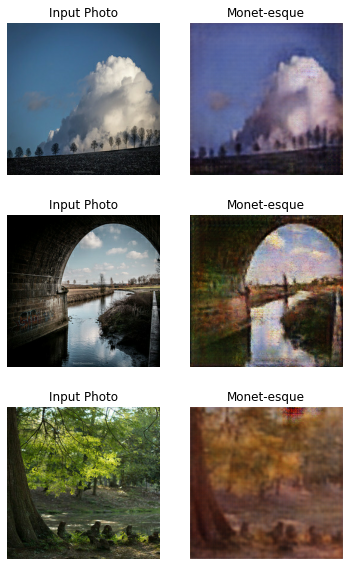

In [85]:
_, ax = plt.subplots(3, 2, figsize=(6, 10))
for i, img in enumerate(photo_df.take(3)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [35]:
files = [r'C:\Users\Rakhat\Documents\dl project\photo_jpg\0aaf6960c4.jpg', r'C:\Users\Rakhat\Documents\dl project\photo_jpg\0ae5e9bfe2.jpg', r'C:\Users\Rakhat\Documents\dl project\photo_jpg\0cb6683555.jpg']

In [36]:
import zipfile
from keras.preprocessing.image import array_to_img
from io import BytesIO

def generate_and_save(generator, ds):
    count = 0
    if os.path.exists('images.zip'):
        os.remove('images.zip')
    with zipfile.ZipFile('images.zip', 'w') as zipf:
        for images_batch in ds:
            images_batch = images_batch[None, ...]
            predictions = generator(images_batch, training=False)
            for pred in predictions:
                count += 1
                generated_image = array_to_img(pred)
                generated_image_bytes = BytesIO()
                generated_image.save(generated_image_bytes, format='JPEG')
                generated_image_bytes.seek(0)
                zipf.writestr(f'generated_image_{count}.jpg', generated_image_bytes.getvalue())
                if count % 1024 == 0:
                    print(f'Archived images: {count}')

In [40]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
    return dataset

In [42]:
photo_df = load_dataset(files, labeled=True).batch(1)

In [67]:
image1 = Image.imread(r'C:\Users\Rakhat\Documents\dl project\photo_jpg\0cb6683555.jpg')

In [68]:
image1 = image1[None, ...]

In [69]:
pred1 = monet_generator(image1, training=False)

In [70]:
pred1 = pred1[0].numpy()

In [71]:
pred1 = (pred1 * 127.5 + 127.5).astype(np.uint8)

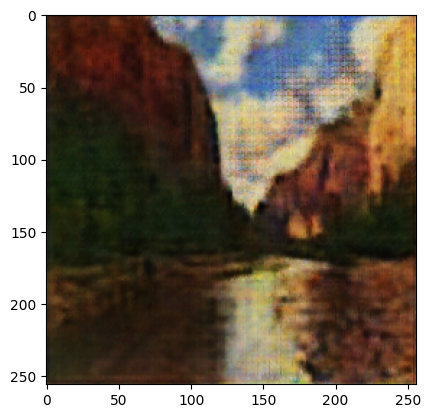

In [72]:
plt.imshow(pred1)

In [38]:
test_photo_ds = load_dataset(files)

In [90]:
cycle_gan_model.save_weights('C:/Users/Rakhat/Documents/dl project/baseline_checkpoints/checkpoints_400/cycle_gan')

In [46]:
cycle_gan_model.load_weights('C:/Users/Rakhat/Documents/dl project/baseline_checkpoints/checkpoints_400/cycle_gan')